In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

import json

from fycharts.SpotifyCharts import SpotifyCharts
import sqlalchemy

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from datetime import datetime
from sklearn.model_selection import train_test_split

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller  

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

# Reading in data

In [2]:
italy_17_19 = pd.read_pickle('../data/it_17_19_v50_feat.pkl')
spain_17_19 = pd.read_pickle('../data/sp_17_19_v50_feat.pkl')
greece_17_19 = pd.read_pickle('../data/gr_17_19_v50_feat.pkl')

italy_20 = pd.read_pickle('../data/it_20_v50_feat.pkl')
spain_20 = pd.read_pickle('../data/sp_20_v50_feat.pkl')
greece_20 = pd.read_pickle('../data/gr_20_v50_feat.pkl')

In [4]:
spain_20.tail(2)

,Position,Track Name,Artist,region,spotify_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,,,,,
2021-02-13,49,La Luz - A COLORS SHOW,María José Llergo,es,5jRnVQbjB6qgN3MARS4xw7,0.722,0.357,9,-10.487,0,0.0996,0.81400,0.155000,0.0863,0.641,149.895,191599,4
2021-02-13,50,Boku no Sensou - TV Size,Shinsei Kamattechan,es,3tRPfCFAEv6wWyQO0YnGGV,0.447,0.891,9,-4.776,1,0.0788,0.00447,0.000905,0.3900,0.517,143.976,90960,4


# Preprocessing data 

#### _Data for each country is split into different dataframes as different combinations and aggregations are needed for different functions._ 

**Resampling by month**

_`rm` denotes resampling by month._ 

In [5]:
rm_italy_17_19 = italy_17_19.resample("M").mean()
rm_spain_17_19 = spain_17_19.resample("M").mean()
rm_greece_17_19 = greece_17_19.resample("M").mean()

rm_italy_20 = italy_20.resample("M").mean()
rm_spain_20 = spain_20.resample("M").mean()
rm_greece_20 = greece_20.resample("M").mean()

**Resampling by week**

_`rw` denotes resampling by week._ 

In [6]:
rw_italy_17_19 = italy_17_19.resample("W").mean()
rw_spain_17_19 = spain_17_19.resample("W").mean()
rw_greece_17_19 = greece_17_19.resample("W").mean()

rw_italy_20 = italy_20.resample("W").mean()
rw_spain_20 = spain_20.resample("W").mean()
rw_greece_20 = greece_20.resample("W").mean()

#### Combining weekly resampled data for all years (2017-2020)

In [7]:
alltime_italy = pd.concat([italy_17_19, italy_20])
alltime_spain = pd.concat([spain_17_19, spain_20])
alltime_greece = pd.concat([greece_17_19, greece_20])

alltime_rw_italy = alltime_italy.resample("W").mean()
alltime_rw_spain = alltime_spain.resample("W").mean()
alltime_rw_greece = alltime_greece.resample("W").mean()

#### Splitting into dataframes for each year! 

In [8]:
it_rw_17 = alltime_rw_italy[0:53]
it_rw_18 = alltime_rw_italy[53:105]
it_rw_19 = alltime_rw_italy[105:158]

In [9]:
it_rw_18.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2018-12-23,25.5,0.652526,0.62446,5.345714,-7.126363,0.548571,0.098575,0.315516,0.058491,0.126928,0.464983,117.940511,209852.965714,3.985714
2018-12-30,25.5,0.637171,0.63514,4.971429,-6.814571,0.528571,0.104640,0.342631,0.066215,0.139117,0.460786,121.689883,216545.840000,3.934286


# Differencing Data for Stationarity

### Augmented Dickey-Fuller test to estimate whether data are stationary. 

In [10]:
audio_features = [
'danceability', 
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [11]:
# Code by Joseph Nelson! 

def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:3], index=['Test Statistic', 'p-value', 'lags_used'])
    return dfoutput

_Dickey-Fuller on original dataframes_

In [12]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}:\n{interpret_dftest(adfuller(alltime_rw_italy[feature]))}')

Dickey-Fuller Interpretation for danceability:
Test Statistic   -3.013333
p-value           0.033668
lags_used         4.000000
dtype: float64
Dickey-Fuller Interpretation for energy:
Test Statistic   -3.470516
p-value           0.008777
lags_used         9.000000
dtype: float64
Dickey-Fuller Interpretation for key:
Test Statistic   -6.335745e+00
p-value           2.833617e-08
lags_used         4.000000e+00
dtype: float64
Dickey-Fuller Interpretation for loudness:
Test Statistic   -3.355416
p-value           0.012576
lags_used         7.000000
dtype: float64
Dickey-Fuller Interpretation for mode:
Test Statistic   -6.787062e+00
p-value           2.417084e-09
lags_used         0.000000e+00
dtype: float64
Dickey-Fuller Interpretation for speechiness:
Test Statistic   -4.108187
p-value           0.000939
lags_used         2.000000
dtype: float64
Dickey-Fuller Interpretation for acousticness:
Test Statistic   -4.022911
p-value           0.001295
lags_used         2.000000
dtype: float64
Dic

### DataFrame with once-differenced data

In [13]:
lag_df_italy = alltime_rw_italy.copy()

In [14]:
for feature in audio_features: 
    lag_df_italy[f'{feature}_once_differenced'] = lag_df_italy[feature].diff(1).fillna(0)

In [15]:
lag_df_italy.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,energy_once_differenced,key_once_differenced,loudness_once_differenced,mode_once_differenced,speechiness_once_differenced,acousticness_once_differenced,instrumentalness_once_differenced,liveness_once_differenced,valence_once_differenced,tempo_once_differenced
date,,,,,,,,,,,,,,,,,,,,,
2021-02-07,25.5,0.666561,0.634389,5.402857,-6.677991,0.680000,0.109192,0.268234,0.035348,0.223654,...,0.029374,0.18000,0.314663,0.031429,-0.001159,-0.073344,-0.001695,0.005719,-0.006398,3.285271
2021-02-14,25.5,0.671104,0.647343,5.516667,-6.842603,0.656667,0.120716,0.277941,0.054173,0.220087,...,0.012955,0.11381,-0.164612,-0.023333,0.011523,0.009707,0.018826,-0.003567,0.049983,1.041837


_Dickey-Fuller on lag dataframe_

In [16]:
for feature in audio_features:
    print(f'Dickey-Fuller Interpretation for {feature}, once-differenced:\n{interpret_dftest(adfuller(lag_df_italy[feature].diff(1).fillna(0)))}')

Dickey-Fuller Interpretation for danceability, once-differenced:
Test Statistic   -9.142255e+00
p-value           2.828632e-15
lags_used         5.000000e+00
dtype: float64
Dickey-Fuller Interpretation for energy, once-differenced:
Test Statistic   -6.782611e+00
p-value           2.477455e-09
lags_used         7.000000e+00
dtype: float64
Dickey-Fuller Interpretation for key, once-differenced:
Test Statistic   -8.518281e+00
p-value           1.118537e-13
lags_used         7.000000e+00
dtype: float64
Dickey-Fuller Interpretation for loudness, once-differenced:
Test Statistic   -7.002232e+00
p-value           7.272028e-10
lags_used         6.000000e+00
dtype: float64
Dickey-Fuller Interpretation for mode, once-differenced:
Test Statistic   -9.845662e+00
p-value           4.627101e-17
lags_used         4.000000e+00
dtype: float64
Dickey-Fuller Interpretation for speechiness, once-differenced:
Test Statistic   -8.291616e+00
p-value           4.246658e-13
lags_used         5.000000e+00
dtype

_Checking that these are the same_

In [17]:
interpret_dftest(adfuller(lag_df_italy['tempo_once_differenced']))

Test Statistic   -6.454214e+00
p-value           1.497350e-08
lags_used         1.400000e+01
dtype: float64

In [18]:
interpret_dftest(adfuller(lag_df_italy['tempo'].diff(1).fillna(0)))

Test Statistic   -6.454214e+00
p-value           1.497350e-08
lags_used         1.400000e+01
dtype: float64

### Using `ndiffs` to figure out how many orders of difference $d$ I need in oder to have stationarity

In [19]:
from pmdarima.arima.utils import ndiffs

In [22]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(alltime_italy[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 0
ndiffs for energy stationarity w/ adf test: 0
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 0
ndiffs for mode stationarity w/ adf test: 0
ndiffs for speechiness stationarity w/ adf test: 0
ndiffs for acousticness stationarity w/ adf test: 0
ndiffs for instrumentalness stationarity w/ adf test: 0
ndiffs for liveness stationarity w/ adf test: 0
ndiffs for valence stationarity w/ adf test: 0
ndiffs for tempo stationarity w/ adf test: 0


In [23]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ adf test: {ndiffs(alltime_rw_italy[feature], test= "adf")}')

ndiffs for danceability stationarity w/ adf test: 1
ndiffs for energy stationarity w/ adf test: 0
ndiffs for key stationarity w/ adf test: 0
ndiffs for loudness stationarity w/ adf test: 0
ndiffs for mode stationarity w/ adf test: 1
ndiffs for speechiness stationarity w/ adf test: 0
ndiffs for acousticness stationarity w/ adf test: 0
ndiffs for instrumentalness stationarity w/ adf test: 0
ndiffs for liveness stationarity w/ adf test: 0
ndiffs for valence stationarity w/ adf test: 0
ndiffs for tempo stationarity w/ adf test: 0


In [24]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(alltime_italy[feature])}')

ndiffs for danceability stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1
ndiffs for key stationarity w/ kpss test: 1
ndiffs for loudness stationarity w/ kpss test: 1
ndiffs for mode stationarity w/ kpss test: 1
ndiffs for speechiness stationarity w/ kpss test: 1
ndiffs for acousticness stationarity w/ kpss test: 1
ndiffs for instrumentalness stationarity w/ kpss test: 1
ndiffs for liveness stationarity w/ kpss test: 1
ndiffs for valence stationarity w/ kpss test: 1
ndiffs for tempo stationarity w/ kpss test: 1


In [25]:
for feature in audio_features:
    print(f'ndiffs for {feature} stationarity w/ kpss test: {ndiffs(alltime_rw_italy[feature])}')

ndiffs for danceability stationarity w/ kpss test: 1
ndiffs for energy stationarity w/ kpss test: 1
ndiffs for key stationarity w/ kpss test: 0
ndiffs for loudness stationarity w/ kpss test: 0
ndiffs for mode stationarity w/ kpss test: 0
ndiffs for speechiness stationarity w/ kpss test: 1
ndiffs for acousticness stationarity w/ kpss test: 1
ndiffs for instrumentalness stationarity w/ kpss test: 1
ndiffs for liveness stationarity w/ kpss test: 1
ndiffs for valence stationarity w/ kpss test: 1
ndiffs for tempo stationarity w/ kpss test: 0


### Finding `p`, `d`, and `q` values

_Using only the five audio features that are the most relevant or show some sort of pattern_ 

In [26]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'tempo']

_Building dataframe with `ndifffs` for stationarity for each feature_

In [27]:
ndiff_dict = {
    'audio_feature':[],
    'ndiffs for stationarity':[]    
}

for feature in five_features:
    ndiff_dict['audio_feature'].append(feature)
    ndiff_dict['ndiffs for stationarity'].append(ndiffs(alltime_rw_italy[feature], test= "adf"))

ndiff_df = pd.DataFrame(ndiff_dict)
ndiff_df

,audio_feature,ndiffs for stationarity
0,danceability,1
1,mode,1
2,acousticness,0
3,valence,0
4,tempo,0


In [28]:
arima_dict = {
    'audio_feature':[],
    'ndiffs(d)':[],
    'best_p':[],
    'best_q':[],
    'order':[],
    'ARIMA_model':[],
    'ARIMA_AIC':[]
}

def find_p_and_q(df, feature, n=6):
    
    train = df[feature][0:162]
    
    d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]

    # starting with large start AIC
    best_aic = 99 * (10 * 16)
    # creating variables to store best values ofd p and q 
    best_p = 0
    best_q = 0 

    # use nested for loop to iterate over values of p and q
    for p in range(n):

        for q in range(n):

            # insert try and and except statements
            try: 

                # fitting on ARIMA(p, 1, q) model 
                print(f'Attempting to fit ARIMA({p}, {d}, {q})')

                # instantiate ARIMA model
                arima = ARIMA(train, order=(p,d,q))

                # fit ARIMA model 
                model = arima.fit()

                # print out AIC for ARIMA(p, 1, q) model 
                print(f'For {feature}, the AIC for ARIMA({p},{d},{q}) is: {model.aic}')

                # Is this current model's AIC better than the OF best_aic? 
                if model.aic < best_aic:
                    # we want aic to be lower so we are setting a high aic and hoping for something lower 

                    # if it is, we overwrite the best_aic, best_p, and best_q
                    best_aic = model.aic
                    best_p = p 
                    best_q = q

            except:
                pass 

        order = (best_p, d, best_q)
    
    arima_dict['audio_feature'].append(feature)
    arima_dict['ndiffs(d)'].append(d)
    arima_dict['best_p'].append(best_p)
    arima_dict['best_q'].append(best_q)
    arima_dict['order'].append(order)
    arima_dict['ARIMA_model'].append(f'ARIMA({best_p},{d},{best_q})')
    arima_dict['ARIMA_AIC'].append(best_aic)

    print()
    print(f'{feature.upper()} MODEL FINISHED!')
    print(f'The model for {feature} that minimizes AIC on the training data is the ARIMA({best_p},{d},{best_q}).')
    print(f'The model has an aIC of {best_aic}.')
    print()

In [29]:
arima_dict

{'audio_feature': [],
 'ndiffs(d)': [],
 'best_p': [],
 'best_q': [],
 'order': [],
 'ARIMA_model': [],
 'ARIMA_AIC': []}

In [30]:
for feature in five_features:
    find_p_and_q(rw_italy_17_19, feature)

Attempting to fit ARIMA(0, 1, 0)
For danceability, the AIC for ARIMA(0,1,0) is: -705.1269635218952
Attempting to fit ARIMA(0, 1, 1)
For danceability, the AIC for ARIMA(0,1,1) is: -719.9078122241333
Attempting to fit ARIMA(0, 1, 2)
For danceability, the AIC for ARIMA(0,1,2) is: -719.3145992186896
Attempting to fit ARIMA(0, 1, 3)
For danceability, the AIC for ARIMA(0,1,3) is: -719.0058383050268
Attempting to fit ARIMA(0, 1, 4)
For danceability, the AIC for ARIMA(0,1,4) is: -718.7836792929766
Attempting to fit ARIMA(0, 1, 5)
For danceability, the AIC for ARIMA(0,1,5) is: -716.8215644624875
Attempting to fit ARIMA(1, 1, 0)
For danceability, the AIC for ARIMA(1,1,0) is: -716.4336321379885
Attempting to fit ARIMA(1, 1, 1)
For danceability, the AIC for ARIMA(1,1,1) is: -725.3103525337362
Attempting to fit ARIMA(1, 1, 2)
For danceability, the AIC for ARIMA(1,1,2) is: -726.847242195727
Attempting to fit ARIMA(1, 1, 3)
Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(1, 1, 5)
Attempting 

In [31]:
arima_param_df = pd.DataFrame(arima_dict)
arima_param_df

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC
0,danceability,1,2,1,"(2, 1, 1)","ARIMA(2,1,1)",-726.878719
1,mode,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",-430.794979
2,acousticness,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",-600.573624
3,valence,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",-627.919164
4,tempo,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)",780.783703


# ARIMA Models  

### Function to create, evaluate, and plot `ARIMA` models 

In [153]:
def arima_predict_plot(df, feature, year, title='title', figsize=(15,5), order=None, d=None, ci=True):
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    if order is None:
        # find order from arima parameters dataframe 
        order = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
   
    # instantiate ARIMA model
    model = ARIMA(train, order=order)

    # fit ARIMA model
    arima = model.fit()
    
    # get predictions for train and test sets 
    preds_train = model.predict(params=arima.params, start=train.index[d], end=train.index[-1], typ='levels')
    preds_test = model.predict(params=arima.params, start=test.index[0], end=test.index[-1], typ='levels')
    
    # calculate and print RMSE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}): {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}): {test_rmse}')
    
    # add RMSEs to arima parameters dataframe 
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'arima_train_rmse'] = train_rmse    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'arima_test_rmse'] = test_rmse
    
      # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

_Function soley for plotting to be used when needed._

In [109]:
def arima_plot(train, test, preds_test, title='title', figsize=(15,5), ci=True):
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval 
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

### ARIMA Models - 2017

_Using `arima_predict_plot` function to run ARIMA model for each feature and show plot of actual vs. test._

_This will also add columns for `arima_train_rmse` and `arima_test_rmse`._

In [58]:
it_rw_17.head(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2017-01-01,25.5,0.604800,0.591096,5.840000,-9.008200,0.600000,0.081670,0.303003,0.061578,0.172262,0.466054,115.511720,257468.600000,3.860000
2017-01-08,25.5,0.592829,0.596115,5.602857,-8.670323,0.717143,0.091595,0.355359,0.182476,0.175617,0.390494,118.564109,279987.502857,3.908571


In [59]:
it_rw_17.tail(2)

,Position,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
date,,,,,,,,,,,,,,
2017-12-24,25.5,0.612843,0.674063,5.302857,-6.309091,0.657143,0.123394,0.253601,0.013014,0.179737,0.443628,108.77560,221529.465714,3.900000
2017-12-31,25.5,0.610449,0.656787,5.637143,-6.322729,0.688571,0.102279,0.209149,0.022378,0.171537,0.415203,116.60734,218028.402857,3.908571


d = 1
order = (2, 1, 1)
Danceability train RMSE (2017) - ARIMA((2, 1, 1)): 0.026155679271466482
Danceability test RMSE (2017) - ARIMA((2, 1, 1)): 0.012447651046008791


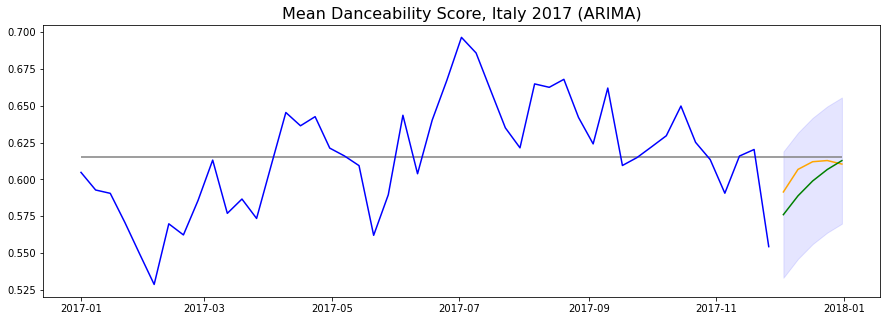

d = 1
order = (4, 1, 3)
Mode train RMSE (2017) - ARIMA((4, 1, 3)): 0.06930739102964396
Mode test RMSE (2017) - ARIMA((4, 1, 3)): 0.1453825018651371


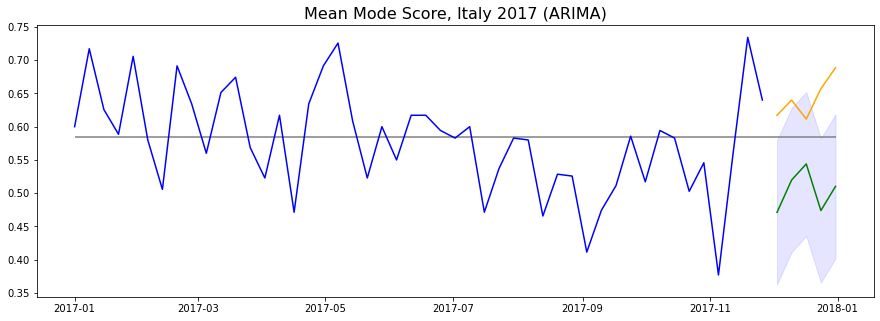

d = 0
order = (3, 0, 2)
Acousticness train RMSE (2017) - ARIMA((3, 0, 2)): 0.038503210673536924
Acousticness test RMSE (2017) - ARIMA((3, 0, 2)): 0.031290359571656025


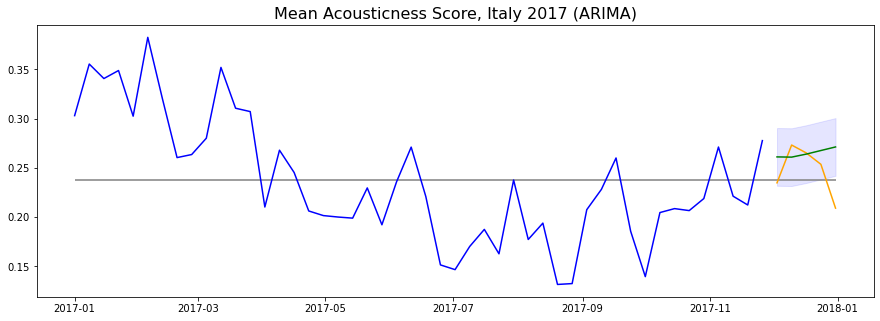

d = 0
order = (2, 0, 2)
Valence train RMSE (2017) - ARIMA((2, 0, 2)): 0.035572561609325974
Valence test RMSE (2017) - ARIMA((2, 0, 2)): 0.03332529150268263


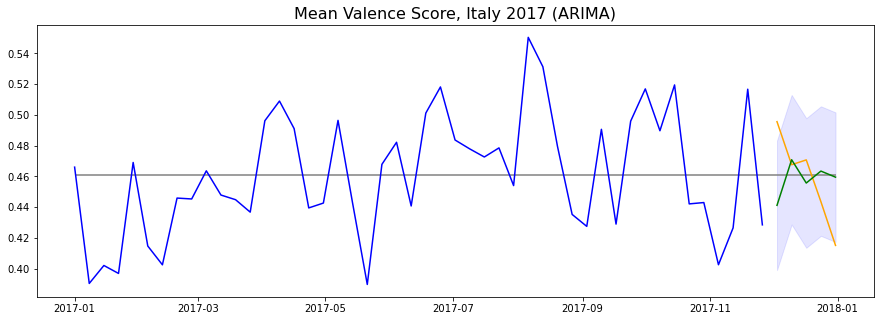

d = 0
order = (0, 0, 5)
Tempo train RMSE (2017) - ARIMA((0, 0, 5)): 2.937924521744971
Tempo test RMSE (2017) - ARIMA((0, 0, 5)): 7.1202523963668725


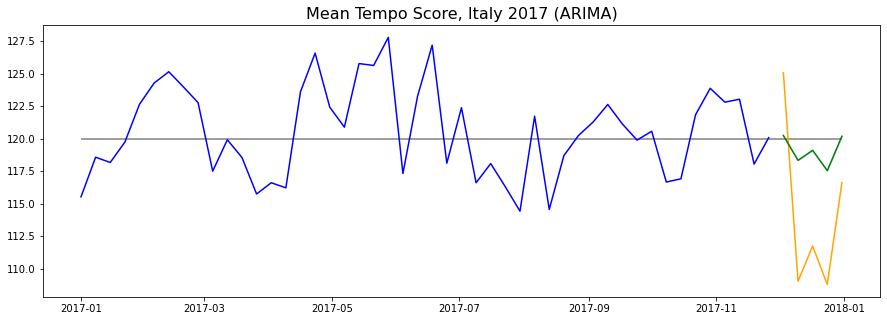

In [103]:
for feature in five_features: 
    arima_predict_plot(it_rw_17, feature, 2017, title=f'Mean {feature.capitalize()} Score, Italy 2017 (ARIMA)')

#### _Updated `arima_param_df`_

In [78]:
arima_param_df

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse
0,danceability,1,2,1,"(2, 1, 1)","ARIMA(2,1,1)",-726.878719,0.026156,0.012448
1,mode,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",-430.794979,0.069307,0.145383
2,acousticness,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",-600.573624,0.038503,0.031290
3,valence,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",-627.919164,0.035573,0.033325
4,tempo,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)",780.783703,2.937925,7.120252


# SARIMAX models 

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### _As baseline, Fitting SARIMAX with `seasonal_order = (2, 0, 2, 52)` and no exogenous variables before incorporating/engineering those components._

RMSE = 0.05


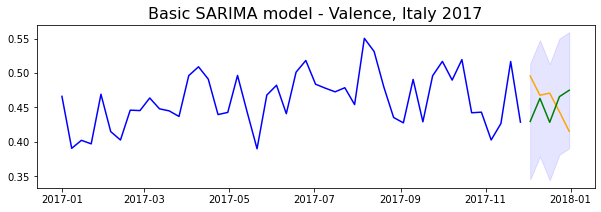

In [76]:
P, D, Q, S = 2, 0 ,2, 52
train_val = it_rw_17['valence'][0:48]
test_val = it_rw_17['valence'][48:]

sarima_val = SARIMAX(endog = train_val, order = (2, 0, 2), seasonal_order = (P, D, Q, S)).fit()
# sarima_pred = sarima.predict(start=start, end = end)

preds_train_sarima_val = sarima_val.predict(start=train_val.index[0], end=train_val.index[-1])
preds_test_sarima_val = sarima_val.predict(start=test_val.index[0], end=test_val.index[-1])

print(f'RMSE = {round(mean_squared_error(test_val, preds_test_sarima_val)**.5, 2)}')

arima_plot(train_val, test_val, preds_test_sarima_val, title="Basic SARIMA model - Valence, Italy 2017", figsize=(10,3))

#### Plotting ARIMA plot from above again, for comparison: 

d = 0
order = (2, 0, 2)
Valence train RMSE (2017) - ARIMA((2, 0, 2)): 0.035572561609325974
Valence test RMSE (2017) - ARIMA((2, 0, 2)): 0.03332529150268263


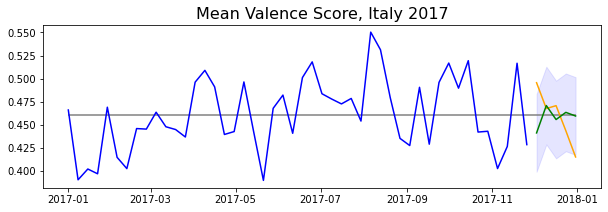

In [77]:
arima_predict_plot(it_rw_17, 'valence', 2017, title=f'Mean Valence Score, Italy 2017', figsize=(10,3))

### SARIMAX Seasonal Parameters

#### _Grid search to find best `P`, `D`, `Q`, and `s` values_

In [139]:
def find_sarima_parameters(df, feature, n_rows=47):    
    
    import time
    t0 = time.time()
    final_mae = 1000000000000
    final_S = 0
    final_D = 0
    final_P = 0
    final_Q = 0
    
    # find order from arima parameters dataframe 
    order = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'order'].iloc[0]

    train_values = df[feature][0:n_rows]
    test_values = df[feature][n_rows:]

    for S in range(48,53):
        for D in range(2):
            for P in range(4):
                for Q in range(4):
                    print(f'Checking ({P}, {D}, {Q}, {S}) at {round(time.time() - t0)} seconds.')
                    try:
                        sarima = SARIMAX(endog = train_values,
                                         order = order,
                                         seasonal_order = (P, D, Q, S)).fit()

                        sarima_pred = sarima.predict(start=test_values.index[0], end=test_values.index[-1], typ='levels')

                        if mean_absolute_error(test_values, sarima_pred) < final_mae:
                            final_mae = mean_absolute_error(test_values, sarima_pred)
                            final_S = S
                            final_D = D
                            final_P = P
                            final_Q = Q

                        print(f'We just fit a SARIMAX(2, 0, 2)x({P}, {D}, {Q}, {S}) model with {mean_absolute_error(test_values, sarima_pred)} MAE and {mean_squared_error(test_values, sarima_pred)**0.5} RMSE.')

                    except:
                        print('problem!')
                        raise

    print()
    print(f'The final model for {feature} is SARIMAX(2, 0, 2)x({final_P}, {final_D}, {final_Q}, {final_S}).')
    print()

In [140]:
five_features

['danceability', 'mode', 'acousticness', 'valence', 'tempo']

In [141]:
for feature in five_features: 
    find_sarima_parameters(it_rw_17, feature)

Checking (0, 0, 0, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 0, 48) model with 0.02535439624913416 MAE and 0.03235024699693846 RMSE.
Checking (0, 0, 1, 48) at 0 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 1, 48) model with 0.02530012454173834 MAE and 0.03235445125658867 RMSE.
Checking (0, 0, 2, 48) at 1 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 2, 48) model with 0.02522953394499224 MAE and 0.03231597528729935 RMSE.
Checking (0, 0, 3, 48) at 4 seconds.
We just fit a SARIMAX(2, 0, 2)x(0, 0, 3, 48) model with 0.025200232385478194 MAE and 0.032300443440283794 RMSE.
Checking (1, 0, 0, 48) at 12 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 0, 48) model with 0.025351736406543812 MAE and 0.03236137962655508 RMSE.
Checking (1, 0, 1, 48) at 14 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 1, 48) model with 0.025072120974000744 MAE and 0.032271091282727773 RMSE.
Checking (1, 0, 2, 48) at 15 seconds.
We just fit a SARIMAX(2, 0, 2)x(1, 0, 2, 48) model with 0.028274897847032

Results from above:
+ The final model for danceability is SARIMAX(2, 0, 2)x(3, 0, 0, 48).
+ The final model for mode is SARIMAX(2, 0, 2)x(1, 0, 1, 52).
+ The final model for acousticness is SARIMAX(2, 0, 2)x(1, 0, 2, 48).
+ The final model for valence is SARIMAX(2, 0, 2)x(0, 0, 1, 49).
+ The final model for tempo is SARIMAX(2, 0, 2)x(2, 0, 0, 49).

#### _Adding Seasonal Orders to `arima_param_df`_

citation: converting string to tuple https://www.geeksforgeeks.org/python-convert-string-to-tuple/

In [97]:
arima_param_df.loc[arima_param_df['audio_feature'] == 'danceability', 'seasonal_order'] = '3, 0, 0, 48'
arima_param_df.loc[arima_param_df['audio_feature'] == 'mode', 'seasonal_order'] = '1, 0, 1, 52'
arima_param_df.loc[arima_param_df['audio_feature'] == 'acousticness', 'seasonal_order'] = '1, 0, 2, 48'
arima_param_df.loc[arima_param_df['audio_feature'] == 'valence', 'seasonal_order'] = '0, 0, 1, 49'
arima_param_df.loc[arima_param_df['audio_feature'] == 'tempo', 'seasonal_order'] = '2, 0, 0, 49'

#### _Updated `arima_param_df`_

In [98]:
arima_param_df

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order
0,danceability,1,2,1,"(2, 1, 1)","ARIMA(2,1,1)",-726.878719,0.026156,0.012448,"3, 0, 0, 48"
1,mode,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",-430.794979,0.069307,0.145383,"1, 0, 1, 52"
2,acousticness,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",-600.573624,0.038503,0.031290,"1, 0, 2, 48"
3,valence,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",-627.919164,0.035573,0.033325,"0, 0, 1, 49"
4,tempo,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)",780.783703,2.937925,7.120252,"2, 0, 0, 49"


#### _Function for SARIMA w/ seasonal components, no exogenous variables:_

In [142]:
def sarima_predict_plot_seasonal(df, feature, year, output_df, title='title', figsize=(15,5), order=None, d=None, seasonal_order=None, ci=True):
  
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    # find order from arima parameters dataframe 
    if order is None:
        order = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
    
    # find seasonal order from arima parameters dataframe 
    if seasonal_order is None: 
        sea_string = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'seasonal_order'].iloc[0]
        seasonal_order = tuple(map(int, sea_string.split(', '))) 
    print(f'seasonal order = {seasonal_order}')
    
    # instantiate and fit SARIMAX model 
    sarima = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order).fit()

    # get predictions for train and test sets 
    preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels')
    preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels')
    
    # calculate and print RMSE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - SARIMA({order}): {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - SARIMA({order}): {test_rmse}')    
    
    # add RMSEs to arima parameters dataframe 
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'sarima_train_rmse'] = train_rmse    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'sarima_test_rmse'] = test_rmse
    
    # calculate residuals
    # residuals = test - preds_test
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval 
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

d = 1
order = (2, 1, 1)
seasonal order = (3, 0, 0, 48)
Danceability train RMSE (2017) - SARIMA((2, 1, 1)): 0.02604860270283264
Danceability test RMSE (2017) - SARIMA((2, 1, 1)): 0.02129312854030801


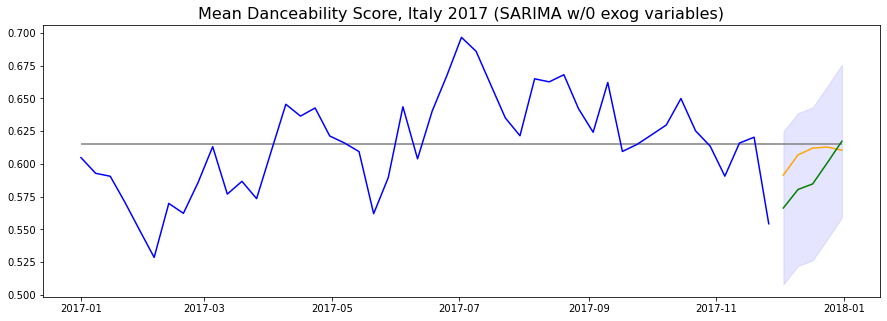

d = 1
order = (4, 1, 3)
seasonal order = (1, 0, 1, 52)
Mode train RMSE (2017) - SARIMA((4, 1, 3)): 0.06662545896440102
Mode test RMSE (2017) - SARIMA((4, 1, 3)): 0.10908603704861933


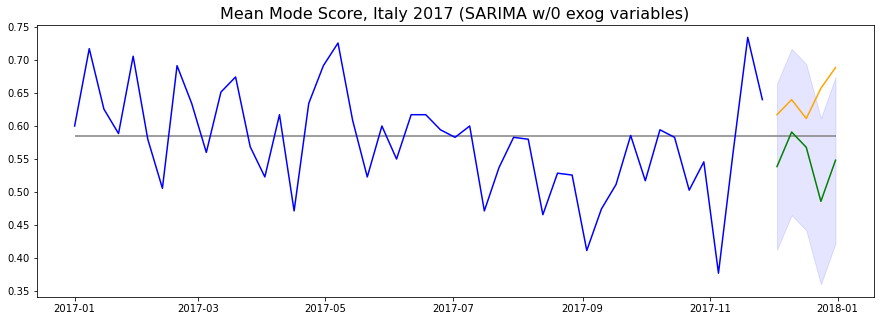

d = 0
order = (3, 0, 2)
seasonal order = (1, 0, 2, 48)
Acousticness train RMSE (2017) - SARIMA((3, 0, 2)): 0.0599604383435671
Acousticness test RMSE (2017) - SARIMA((3, 0, 2)): 0.01943910236962413


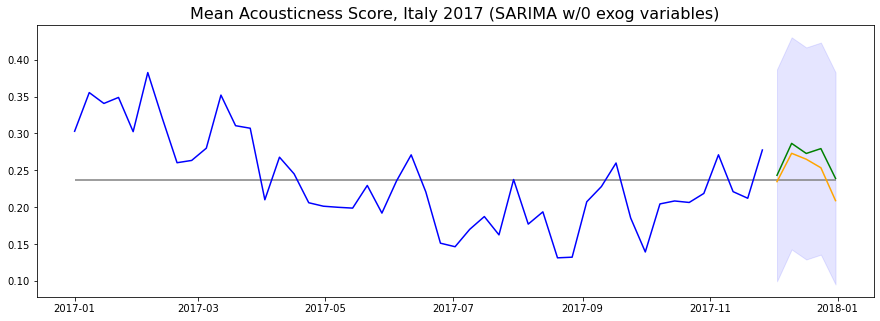

d = 0
order = (2, 0, 2)
seasonal order = (0, 0, 1, 49)
Valence train RMSE (2017) - SARIMA((2, 0, 2)): 0.0762942717827684
Valence test RMSE (2017) - SARIMA((2, 0, 2)): 0.025510262698733292


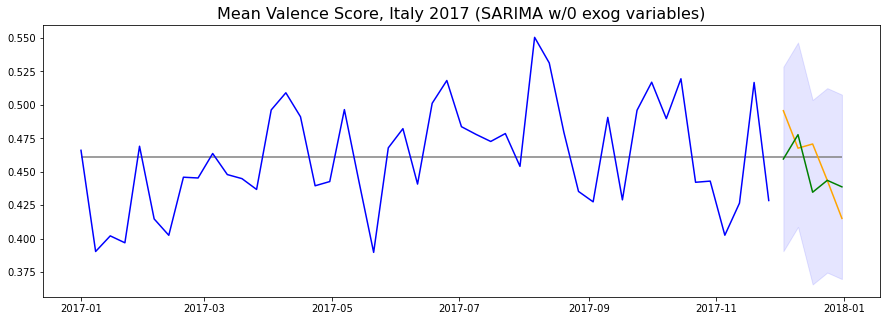

d = 0
order = (0, 0, 5)
seasonal order = (2, 0, 0, 49)
Tempo train RMSE (2017) - SARIMA((0, 0, 5)): 21.276842071246342
Tempo test RMSE (2017) - SARIMA((0, 0, 5)): 14.1784468298147


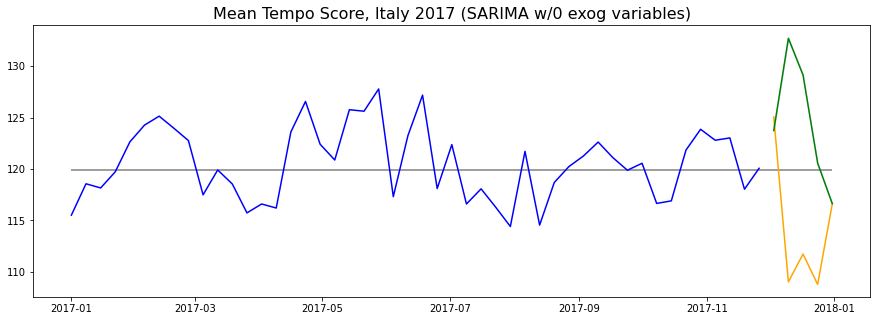

In [143]:
for feature in five_features:
    sarima_predict_plot_seasonal(it_rw_17, feature, 2017, title=f'Mean {feature.capitalize()} Score, Italy 2017 (SARIMA w/0 exog variables)')

#### _Updated `arima_param_df`_

In [105]:
arima_param_df

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,sarima_train_rmse,sarima_test_rmse
0,danceability,1,2,1,"(2, 1, 1)","ARIMA(2,1,1)",-726.878719,0.026156,0.012448,"3, 0, 0, 48",0.026049,0.021293
1,mode,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",-430.794979,0.069307,0.145383,"1, 0, 1, 52",0.066625,0.109086
2,acousticness,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",-600.573624,0.038503,0.031290,"1, 0, 2, 48",0.059960,0.019439
3,valence,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",-627.919164,0.035573,0.033325,"0, 0, 1, 49",0.076294,0.025510
4,tempo,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)",780.783703,2.937925,7.120252,"2, 0, 0, 49",21.276842,14.178447


#### _Incorporating Exogenous Variables in SARIMAX models_

In [127]:
def sarima_predict_plot_exog(df, feature, year, exog_var, title='title', figsize=(15,5), order=None, d=None, seasonal_order=None, ci=True):

    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    # find order from arima parameters dataframe 
    if order is None:
        order = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
    
    # find seasonal order from arima parameters dataframe 
    if seasonal_order is None: 
        sea_string = arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'seasonal_order'].iloc[0]
        seasonal_order = tuple(map(int, sea_string.split(', '))) 
    print(f'seasonal order = {seasonal_order}')
    
    # reshape exogenous features to pass to the model 
    exog = df.loc[:, exog_var]   
   
    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
    
    # instantiate and fit SARIMAX model 
    sarima = SARIMAX(endog=train, exog=exog[0:n_rows], order=order, seasonal_order=seasonal_order).fit()

    # get predictions for train and test sets 
    preds_train = sarima.predict(start=train.index[d], end=train.index[-1], typ='levels', exog=exog[0:n_rows])
    preds_test = sarima.predict(start=test.index[0], end=test.index[-1], typ='levels', exog=exog[n_rows:])
    
    # calculate and print RMSE for train and test setes 
    train_rmse = mean_squared_error(train[d::], preds_train)**0.5
    print(f'{feature.capitalize()} train RMSE ({year}) - SARIMAX({seasonal_order}) w/ exogenous variables: {train_rmse}')

    test_rmse = mean_squared_error(test, preds_test)**0.5
    print(f'{feature.capitalize()} test RMSE ({year}) - SARIMAX({seasonal_order}) w/ exogenous variables: {test_rmse}')    
    
    # add RMSEs to arima parameters dataframe 
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'exog_train_rmse'] = train_rmse    
    arima_param_df.loc[arima_param_df['audio_feature'] == feature, 'exog_test_rmse'] = test_rmse

    # calculate residuals
    # residuals = test - preds_test
    
    # set up plot
    plt.figure(figsize=figsize)
    
    # plot training data 
    plt.plot(train, color='blue')
    
    # plot testing data 
    plt.plot(test.index, test, color='orange')
    
    # plot predicted values for test set 
    plt.plot(test.index, preds_test, color='green')
    
    # add line for the baseline model (mean value of feature)
    plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')
    
    # plot confidence interval 
    if ci:
        ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
        plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 
    
    # make plot with title! 
    plt.title(title, fontsize=16)
    plt.show() ; 

_Identifying exogenous variables for each of the five main features, which for each of them is the other four audio features_

In [130]:
five_features = ['danceability', 'mode', 'acousticness', 'valence', 'tempo']

exog_danceability = ['mode', 'acousticness', 'valence', 'tempo']
exog_mode = ['danceability', 'acousticness', 'valence', 'tempo']
exog_acousticness = ['danceability', 'mode', 'valence', 'tempo']
exog_valence = ['danceability', 'mode', 'acousticness', 'tempo']
exog_tempo = ['danceability', 'mode', 'acousticness', 'valence']

d = 1
order = (2, 1, 1)
seasonal order = (3, 0, 0, 48)
Danceability train RMSE (2017) - SARIMAX((3, 0, 0, 48)) w/ exogenous variables: 0.020428213079817507
Danceability test RMSE (2017) - SARIMAX((3, 0, 0, 48)) w/ exogenous variables: 0.011168623038644306


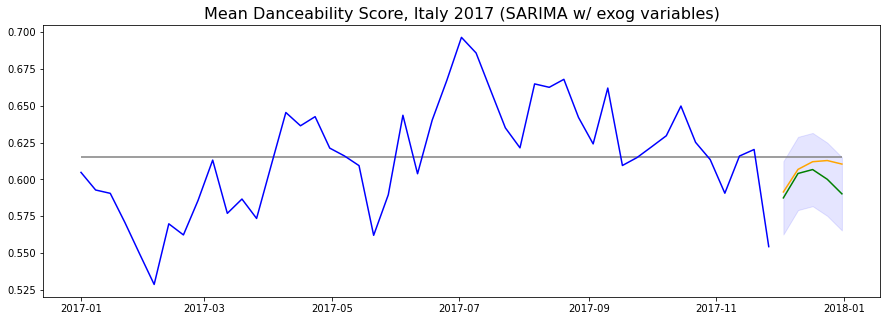

In [128]:
sarima_predict_plot_exog(it_rw_17, 'danceability', 2017, exog_var=exog_danceability, title=f'Mean Danceability Score, Italy 2017 (SARIMA w/ exog variables)')

In [129]:
# for feature in five_features:
#     sarima_predict_plot_exog(it_rw_17, feature, 2017, exog_var=f'exog_{feature}', title=f'Mean {feature} Score, Italy 2017 (SARIMA w/ exog variables)')

d = 1
order = (4, 1, 3)
seasonal order = (1, 0, 1, 52)
Mode train RMSE (2017) - SARIMAX((1, 0, 1, 52)) w/ exogenous variables: 0.06968925672683578
Mode test RMSE (2017) - SARIMAX((1, 0, 1, 52)) w/ exogenous variables: 0.09483950188720432


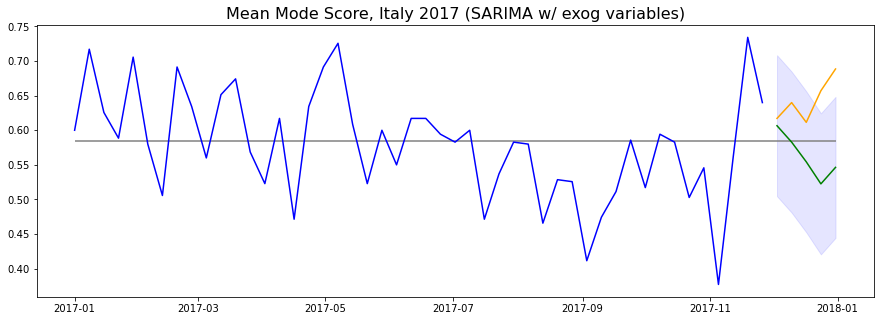

In [131]:
sarima_predict_plot_exog(it_rw_17, 'mode', 2017, exog_var=exog_mode, title=f'Mean Mode Score, Italy 2017 (SARIMA w/ exog variables)')

d = 0
order = (3, 0, 2)
seasonal order = (1, 0, 2, 48)
Acousticness train RMSE (2017) - SARIMAX((1, 0, 2, 48)) w/ exogenous variables: 0.04714988549963703
Acousticness test RMSE (2017) - SARIMAX((1, 0, 2, 48)) w/ exogenous variables: 0.061274495809004396


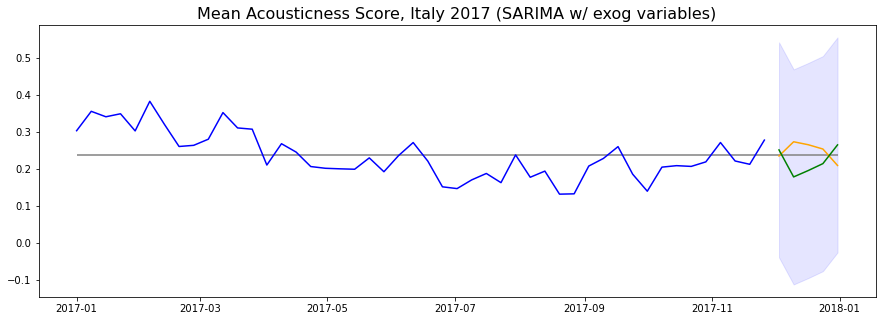

In [132]:
sarima_predict_plot_exog(it_rw_17, 'acousticness', 2017, exog_var=exog_acousticness, title=f'Mean Acousticness Score, Italy 2017 (SARIMA w/ exog variables)')

d = 0
order = (2, 0, 2)
seasonal order = (0, 0, 1, 49)
Valence train RMSE (2017) - SARIMAX((0, 0, 1, 49)) w/ exogenous variables: 0.028125600997224418
Valence test RMSE (2017) - SARIMAX((0, 0, 1, 49)) w/ exogenous variables: 0.03764422244628678


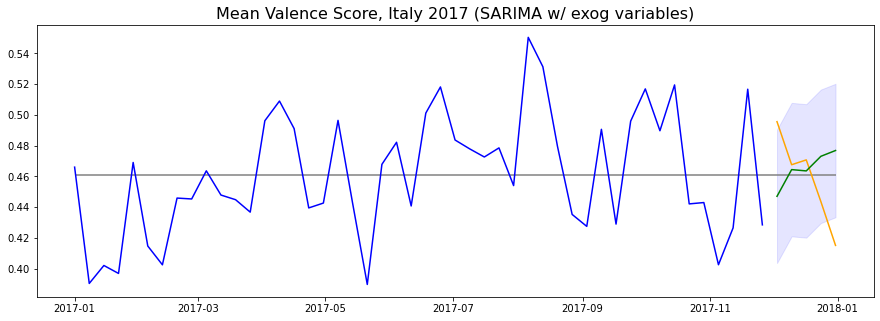

In [133]:
sarima_predict_plot_exog(it_rw_17, 'valence', 2017, exog_var=exog_valence, title=f'Mean Valence Score, Italy 2017 (SARIMA w/ exog variables)')

d = 0
order = (0, 0, 5)
seasonal order = (2, 0, 0, 49)
Tempo train RMSE (2017) - SARIMAX((2, 0, 0, 49)) w/ exogenous variables: 4.990740543623975
Tempo test RMSE (2017) - SARIMAX((2, 0, 0, 49)) w/ exogenous variables: 9.196512674501086


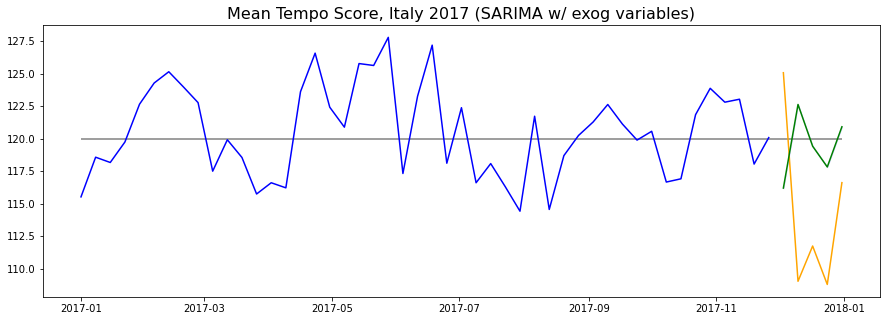

In [134]:
sarima_predict_plot_exog(it_rw_17, 'tempo', 2017, exog_var=exog_tempo, title=f'Mean Tempo Score, Italy 2017 (SARIMA w/ exog variables)')

#### _Updated `arima_param_df`_

In [135]:
arima_param_df

,audio_feature,ndiffs(d),best_p,best_q,order,ARIMA_model,ARIMA_AIC,arima_train_rmse,arima_test_rmse,seasonal_order,sarima_train_rmse,sarima_test_rmse,exog_train_rmse,exog_test_rmse
0,danceability,1,2,1,"(2, 1, 1)","ARIMA(2,1,1)",-726.878719,0.026156,0.012448,"3, 0, 0, 48",0.026049,0.021293,0.020428,0.011169
1,mode,1,4,3,"(4, 1, 3)","ARIMA(4,1,3)",-430.794979,0.069307,0.145383,"1, 0, 1, 52",0.066625,0.109086,0.069689,0.094840
2,acousticness,0,3,2,"(3, 0, 2)","ARIMA(3,0,2)",-600.573624,0.038503,0.031290,"1, 0, 2, 48",0.059960,0.019439,0.047150,0.061274
3,valence,0,2,2,"(2, 0, 2)","ARIMA(2,0,2)",-627.919164,0.035573,0.033325,"0, 0, 1, 49",0.076294,0.025510,0.028126,0.037644
4,tempo,0,0,5,"(0, 0, 5)","ARIMA(0,0,5)",780.783703,2.937925,7.120252,"2, 0, 0, 49",21.276842,14.178447,4.990741,9.196513


# Trying functions with scaled data 

In [144]:
from sklearn.preprocessing import StandardScaler

In [150]:
def arima_predict_plot_scaled(df, feature, year, param_df, title='title', figsize=(15,5), order=None, d=None, ci=True):

    # create train and test sets
    n_rows = round(len(df)*0.9)
    train = df[feature][0:n_rows]
    test = df[feature][n_rows:]
        
    sc = StandardScaler()
    train = sc.fit_transform(train)
    test = sc.transform(test)
    
    # find ndiffs for stationarity from ndiff dataframe
    if d is None: 
        d = ndiff_df.loc[ndiff_df['audio_feature'] == feature, 'ndiffs for stationarity'].iloc[0]
    print(f'd = {d}')
    
    if order is None:
        # find order from arima parameters dataframe 
        order = param_df.loc[param_df['audio_feature'] == feature, 'order'].iloc[0]
    print(f'order = {order}')
   
    try: 
        # instantiate ARIMA model
        model = ARIMA(train, order=order)

        # fit ARIMA model
        arima = model.fit()

        # get predictions for train and test sets 
        preds_train = model.predict(params=arima.params, start=train.index[d], end=train.index[-1], typ='levels')
        preds_test = model.predict(params=arima.params, start=test.index[0], end=test.index[-1], typ='levels')

        # calculate and print RMSE for train and test setes 
        train_rmse = mean_squared_error(train[d::], preds_train)**0.5
        print(f'{feature.capitalize()} train RMSE ({year}) - ARIMA({order}): {train_rmse}')

        test_rmse = mean_squared_error(test, preds_test)**0.5
        print(f'{feature.capitalize()} test RMSE ({year}) - ARIMA({order}): {test_rmse}')

        # add RMSEs to arima parameters dataframe 
#         param_df.loc[param_df['audio_feature'] == feature, 'arima_train_rmse'] = train_rmse    
#         param_df.loc[param_df['audio_feature'] == feature, 'arima_test_rmse'] = test_rmse

          # set up plot
        plt.figure(figsize=figsize)

        # plot training data 
        plt.plot(train, color='blue')

        # plot testing data 
        plt.plot(test.index, test, color='orange')

        # plot predicted values for test set 
        plt.plot(test.index, preds_test, color='green')

        # add line for the baseline model (mean value of feature)
        plt.hlines(df[feature].mean(), train.index[0], test.index[-1], color = 'grey')

        # plot confidence interval
        if ci:
            ci = 1.96 * np.std(preds_test)/np.mean(preds_test)
            plt.fill_between(test.index, (preds_test - ci), (preds_test + ci), color='blue', alpha=.1) 

        # make plot with title! 
        plt.title(title, fontsize=16)
        plt.show() ; 
        
    except:
        print(ValueError)
        pass

In [158]:
arima_predict_plot_scaled(it_rw_17, 'danceability', 2017, arima_param_df)

ValueError: Expected 2D array, got 1D array instead:
array=[0.6048     0.59282857 0.59056143 0.57076    0.54956    0.52865429
 0.56985714 0.56230857 0.58576571 0.61315143 0.57696771 0.58668714
 0.57350286 0.60964857 0.64549714 0.63646571 0.64266286 0.62128571
 0.61599429 0.60939429 0.56203143 0.58959143 0.64360667 0.60387714
 0.64027714 0.66729714 0.69654857 0.68593429 0.66042    0.63507047
 0.62148    0.66491714 0.66260857 0.66802571 0.64213429 0.62415543
 0.66210286 0.60948    0.61487429 0.62222    0.62969143 0.64987714
 0.62521714 0.61349143 0.59064571 0.61590286 0.62035143 0.55434571].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

_Instead of scaling, which didn't work, I will instead add a note about why I don't